In [106]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import time

In [107]:
# Step 1: Load & Preprocess Image
def load_img(path_to_img, max_dim=512):
    img = Image.open(path_to_img).convert('RGB')
    long = max(img.size)
    scale = max_dim / long
    img = img.resize((round(img.size[0] * scale), round(img.size[1] * scale)))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    return tf.keras.applications.vgg19.preprocess_input(img)

def tensor_to_image(tensor):
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        tensor = tensor[0]
    return Image.fromarray(tensor)


In [108]:
# Step 2: Load images
content_path = '/kaggle/input/image-demo-dataset/content2.jpg'
style_path = '/kaggle/input/image-demo-dataset/style3.jpg'

content_image = load_img(content_path)
style_image = load_img(style_path)

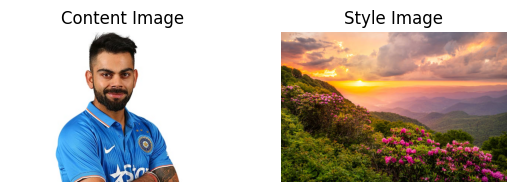

In [109]:
# Step 3: Show input images
plt.subplot(1, 2, 1)
plt.imshow(Image.open(content_path))
plt.title("Content Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(Image.open(style_path))
plt.title("Style Image")
plt.axis('off')
plt.show()


In [110]:
# Step 4: Define VGG layers
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
vgg.trainable = False

content_layers = ['block5_conv2']
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

def vgg_model_layers(layer_names):
    outputs = [vgg.get_layer(name).output for name in layer_names]
    model = tf.keras.Model([vgg.input], outputs)
    return model

def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result / num_locations

class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super().__init__()
        self.vgg = vgg_model_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.vgg.trainable = False

    def call(self, inputs):
        inputs = inputs * 255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:len(self.style_layers)],
                                          outputs[len(self.style_layers):])
        style_outputs = [gram_matrix(style_output) for style_output in style_outputs]
        content_dict = {name: value for name, value in zip(self.content_layers, content_outputs)}
        style_dict = {name: value for name, value in zip(self.style_layers, style_outputs)}
        return {'content': content_dict, 'style': style_dict}


In [111]:
# Step 5: Loss Function
style_weight = 1e-2
content_weight = 1e4

def style_content_loss(outputs, style_targets, content_targets):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name] - style_targets[name])**2)
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name] - content_targets[name])**2)
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    return style_loss + content_loss

In [112]:
# Step 6: Extract features
extractor = StyleContentModel(style_layers, content_layers)
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_264']
Received: inputs=Tensor(shape=(1, 341, 512, 3))
  warnings.warn(msg)


In [113]:
# Step 7: Train (optimize image)
image = tf.Variable(content_image)
opt = tf.optimizers.Adam(learning_rate=0.02)

@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs, style_targets, content_targets)
    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(tf.clip_by_value(image, 0.0, 1.0))

In [114]:
# Step 8: Training loop
epochs = 10
steps_per_epoch = 100

start = time.time()
for n in range(epochs):
    for m in range(steps_per_epoch):
        train_step(image)
    print(f"Epoch {n+1}/{epochs} done.")
end = time.time()
print(f"Total training time: {end - start:.2f}s")

Epoch 1/10 done.
Epoch 2/10 done.
Epoch 3/10 done.
Epoch 4/10 done.
Epoch 5/10 done.
Epoch 6/10 done.
Epoch 7/10 done.
Epoch 8/10 done.
Epoch 9/10 done.
Epoch 10/10 done.
Total training time: 30.69s


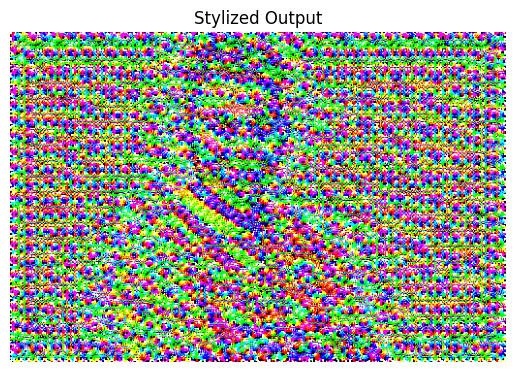

In [115]:
# Step 9: Save & Display output
result = tensor_to_image(image)
result.save("stylized_output.jpg")
plt.imshow(result)
plt.title("Stylized Output")
plt.axis('off')
plt.show()

# **Method-2** Pre-Traind Model from TensorFlow Hub

In [ ]:
import tensorflow_hub as hub
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
import cv2

: 

In [117]:
model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')

In [118]:
def load_image(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = img[tf.newaxis, :]
    return img

In [119]:
content_image = load_image('/kaggle/input/image-demo-dataset/content2.jpg')
style_image = load_image('/kaggle/input/image-demo-dataset/style3.jpg')

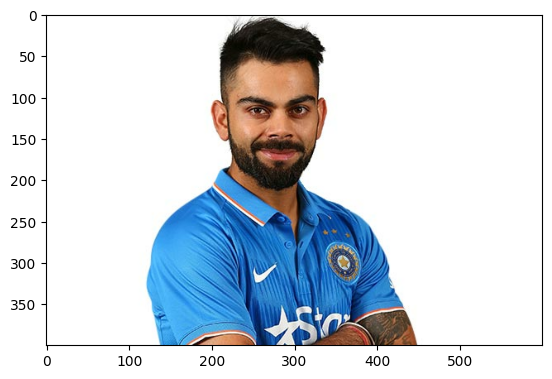

In [120]:
plt.imshow(np.squeeze(content_image))
plt.show()

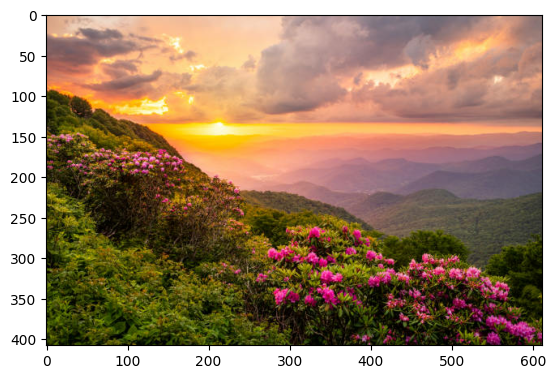

In [121]:
plt.imshow(np.squeeze(style_image))
plt.show()

In [122]:
stylized_image = model(tf.constant(content_image), tf.constant(style_image))[0]

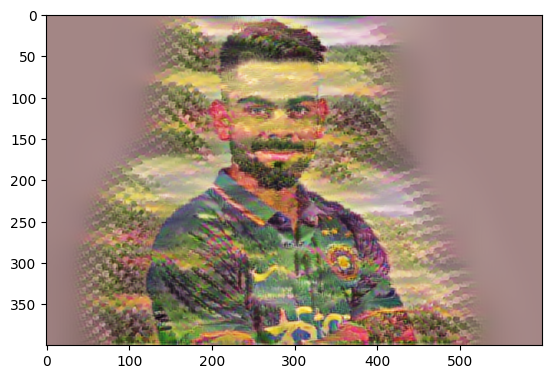

In [123]:
plt.imshow(np.squeeze(stylized_image))
plt.show()